In [1]:
import xtrack as xt
import xobjects as xo
import xpart as xp
from scipy import constants 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ducktrack as dtk

data = np.load('emittance_betacool.npz')
emittance_betacool = data['emittance']
time_betacool = data['time']

gamma0 = 1.004469679
beta0 = np.sqrt(1 - 1 / gamma0**2)
mass0 = 193729.0248722061 * 1e6  # eV/c^2
clight = 299792458.0
p0c = mass0 * beta0 * gamma0  # eV/c
q0 = 54
particle_ref = xp.Particles(p0c=p0c,q0=q0,mass0=mass0,beta0=beta0,gamma0=gamma0)

circumference = 78.54370266  # m
T_per_turn = circumference/(clight*beta0)

qx = 1.82
qy = 2.72
beta_x = 5
beta_y = 5
qs=0.005247746218929317
bets0=-2078.673348423543

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        length=circumference,
        betx=beta_x,
        bety=beta_y,
        )
###############################

arc_matching = xt.LineSegmentMap(
        qx=qx, qy=qy,
        length=circumference,
        betx=beta_x,
        bety=beta_y,
        qs=qs,
        bets=bets0)

line_matching=xt.Line([arc_matching])
line_matching.build_tracker()

num_particles=int(1e3)

#sigma_dp = 2e-3 # Standard LEIR value
sigma_dp = 5e-3 # from Schotttky: 5e-3
 
gemitt_x = 14e-6
gemitt_y = 14e-6

nemitt_x = gemitt_x*beta0*gamma0
nemitt_y = gemitt_y*beta0*gamma0

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        # total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=4.2,
        particle_ref=particle_ref,
        line=line_matching,        
        )

# create desired beam
bunch_intensity = None
sigma_z=-bets0*sigma_dp

particles.delta = np.random.normal(loc=0.0, scale=sigma_dp, size=num_particles)
#particles.zeta = 0
particles.zeta = np.random.uniform(-circumference/2, circumference/2, num_particles)
particles0=particles.copy()

# simulation parameters: simulate 1 s of cooling, and take data once every 10 ms
max_time_s = 1
int_time_s = 1*1e-3

# compute length of simulation, as well as sample interval, in turns
num_turns = int((max_time_s / T_per_turn).item())
save_interval = int((int_time_s / T_per_turn).item())


# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                        n_repetitions=int(num_turns/save_interval),
                        repetition_period=save_interval,
                        num_particles=len(particles.x))

current = 0.6  # amperes
cooler_length = 2.5  # m cooler length
radius_e_beam = 25 * 1e-3
temp_perp = 100e-3 # <E> [eV] = kb*T
temp_long =  1e-3 # <E> [eV]
magnetic_field = 0.075  # T for LEIR
magnetic_field_ratio=1e-3*0

electron_cooler = xt.ElectronCooler(current=current,
                                length=cooler_length,
                                radius_e_beam=radius_e_beam,
                                temp_perp=temp_perp, temp_long=temp_long,
                                magnetic_field=magnetic_field,
                                magnetic_field_ratio=magnetic_field_ratio)

line = xt.Line(elements=[monitor, electron_cooler, arc],element_names=['monitor','electron_cooler','arc'])
                                
line.particle_ref = particle_ref
context = xo.ContextCpu(omp_num_threads=4)
line.build_tracker(_context=context)

particles=particles0.copy()
#particles.q0=charge


#just track all particles, and keep turn-by-turn data (memory expensive!)
line.track(particles, num_turns=num_turns,
        turn_by_turn_monitor=False,with_progress=True)

# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn

# compute actions. for x, remove the dp/p contribution:
action_x = (x**2/beta_x + beta_x*px**2)
# for y, simple compute:
action_y = (y**2/beta_y + beta_y*py**2)
emittance_x=np.mean(action_x, axis=1)/2
norm_emittance_x=np.mean(action_x,axis=1)/2*gamma0*beta0
norm_emittance_y=np.mean(action_y,axis=1)/2*gamma0*beta0

geo_emittance_x=np.mean(action_x,axis=1)/2
geo_emittance_y=np.mean(action_y,axis=1)/2

p0c = particle_ref.p0c
momentum = p0c*delta+p0c                

for i in range(len(time_betacool) - 1, -1, -1):
        if not np.isnan(time_betacool[i]):
                last_non_nan_index = i
                break

time_betacool = time_betacool[:last_non_nan_index]
matched_indices = [np.abs(time - time_value).argmin() for time_value in time_betacool]
emittance_xsuite = [geo_emittance_x[index] for index in matched_indices]
emittance_betacool = emittance_betacool[:last_non_nan_index]
emittance_diff = emittance_xsuite - emittance_betacool
mse_emittance = np.mean(emittance_diff**2)


data_betacool = np.load('force_betacool.npz')
v_diff_betacool = data_betacool['v_diff']
force_betacool = data_betacool['force']
num_particles = int(1e3)

dtk_particle = dtk.TestParticles(
mass0=mass0,
p0c=p0c,
x  = np.random.normal(0, 1e-20, num_particles),
px = np.random.normal(0, 4*np.sqrt(gemitt_x/beta_x), num_particles),
y  = np.random.normal(0, 1e-20, num_particles),
py = np.random.normal(0, 1e-20, num_particles),
delta = np.random.normal(0, 0, num_particles),
zeta  = np.random.normal(0, 0, num_particles),
q0=q0)

dtk_cooler = dtk.elements.ElectronCooler(
current=current, length=cooler_length, radius_e_beam=radius_e_beam,
temp_perp=temp_perp, temp_long=temp_long, magnetic_field=magnetic_field, magnetic_field_ratio=magnetic_field_ratio,
space_charge_factor=0)

force, _, _ = dtk_cooler.force(dtk_particle)

px_tot    = p0c*dtk_particle.px
beta_diff = px_tot/(mass0*gamma0)
v_diff    = beta_diff*clight

sorted_indices = np.argsort(v_diff)
v_diff = v_diff[sorted_indices]
force = force[sorted_indices]
for i in range(len(v_diff_betacool) - 1, -1, -1):
        if not np.isnan(v_diff_betacool[i]):
                last_non_nan_index = i
                break

v_diff_betacool = v_diff_betacool[:last_non_nan_index]

matching_indices = []
for time_value in v_diff_betacool:
        index = np.abs(v_diff - time_value).argmin()
        matching_indices.append(index)

force_xsuite = [force[i] for i in matching_indices]

force_betacool = force_betacool[:last_non_nan_index]

force_diff = force_xsuite - force_betacool
mse_force = np.mean(force_diff**2)

# assert mse_emittance <1e-9
# assert mse_force < 10

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/359700 [00:00<?, ?it/s]

In [2]:
mse_force 

np.float64(1.0550977680775464)

/tmp/pkruyt/ipykernel_159386/2532860007.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


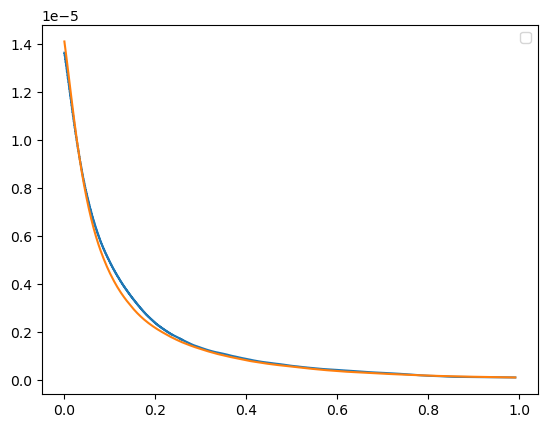

In [3]:
plt.figure()
plt.plot(time_betacool,emittance_xsuite)
plt.plot(time_betacool,emittance_betacool)
plt.legend()
plt.show()



In [4]:
(( 9e+9))**2

8.1e+19

In [5]:
from scipy.constants import m_e as me_kg
me_kg * 3e8**2 / 1.6e-19 #eV


512402.8332093751

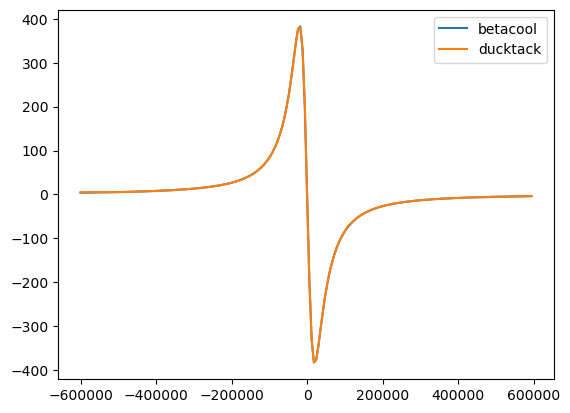

In [6]:
plt.figure()
plt.plot(v_diff_betacool,force_betacool,label='betacool')
plt.plot(v_diff_betacool,force_xsuite,label='ducktack')
plt.legend()
plt.show()